# LSTM with MNIST Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True)

Extracting .\train-images-idx3-ubyte.gz
Extracting .\train-labels-idx1-ubyte.gz
Extracting .\t10k-images-idx3-ubyte.gz
Extracting .\t10k-labels-idx1-ubyte.gz


The argument **(`one_hot=False`)** creates the label arrays as 10-dimensional binary vectors (only zeros and ones), in which the index cell for the number one, is the class label.

In [5]:
trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels 

ntrain = trainimgs.shape[0]
ntest = testimgs.shape[0]
dim = trainimgs.shape[1]
nclasses = trainlabels.shape[1]
print ("Train Images: ", trainimgs.shape)
print ("Train Labels  ", trainlabels.shape)
print ("Test Images:  " , testimgs.shape)
print ("Test Labels:  ", testlabels.shape)

Train Images:  (55000, 784)
Train Labels   (55000, 10)
Test Images:   (10000, 784)
Test Labels:   (10000, 10)


The next code snippet prints the **label vector** (one_hot format), **the class** and actual sample formatted as **image**:

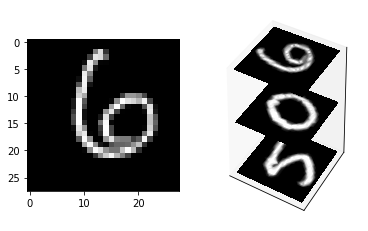

Sample: 100 - Class: [6] - Label Vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 
Sample: 101 - Class: [0] - Label Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Sample: 102 - Class: [5] - Label Vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 


In [6]:
samplesIdx = [100, 101, 102]  #<-- You can change these numbers here to see other samples

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(testimgs[samplesIdx[0]].reshape([28,28]), cmap='gray')
xx, yy = np.meshgrid(np.linspace(0,28,28), np.linspace(0,28,28))
X =  xx ; Y =  yy
Z =  100*np.ones(X.shape)
img = testimgs[77].reshape([28,28])
ax = fig.add_subplot(122, projection='3d')
ax.set_zlim((0,200))
offset=200
for i in samplesIdx:
    img = testimgs[i].reshape([28,28]).transpose()
    ax.contourf(X, Y, img, 200, zdir='z', offset=offset, cmap="gray")
    offset -= 100
    ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

for i in samplesIdx:
    print ("Sample: {0} - Class: {1} - Label Vector: {2} ".format(i, np.nonzero(testlabels[i])[0], testlabels[i]))

#### Our simple RNN consists of  
1. One input layer which converts a $28*28$ dimensional input to an $128$ dimensional hidden layer, 
2. One intermediate recurrent neural network (LSTM) 
3. One output layer which converts an $128$ dimensional output of the LSTM to $10$ dimensional output indicating a class label. 

In [7]:
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)


learning_rate = 0.001
training_iters = 100000
batch_size = 100
display_step = 10

### Construct a RNN

The input should be a Tensor of shape: [batch_size, time_steps, input_dimension], but in our case it would be (?, 28, 28)

In [8]:
x = tf.placeholder(dtype="float", shape=[None, n_steps, n_input], name="x") # Current data input shape: (batch_size, n_steps, n_input) [100x28x28]
y = tf.placeholder(dtype="float", shape=[None, n_classes], name="y")

Lets create the weight and biases for the read out layer

In [9]:
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


Define the lstm cell.

In [12]:
lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

Creating the RNN specified from lstm_cell

In [18]:
outputs, states = tf.nn.dynamic_rnn(lstm_cell, inputs=x, dtype=tf.float32)

The output of the rnn would be a [100x28x128] matrix. we use the linear activation to map it to a [?x10 matrix]

In [19]:
output = tf.reshape(tf.split(outputs, 28, axis=1, num=None, name='split')[-1],[-1,128])
pred = tf.matmul(output, weights['out']) + biases['out']

In [20]:
pred

<tf.Tensor 'add:0' shape=(?, 10) dtype=float32>

Defining the cost function and optimizer.

In [21]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Checking the accuracy of our model

In [22]:
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Just recall that we will treat the MNIST image $\in \mathcal{R}^{28 \times 28}$ as $28$ sequences of a vector $\mathbf{x} \in \mathcal{R}^{28}$. 

In [25]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:

        # We will read a batch of 100 images [100 x 784] as batch_x
        # batch_y is a matrix of [100x10]
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # We consider each row of the image as one sequence
        # Reshape data to get 28 seq of 28 elements, so that, batxh_x is [100x28x28]
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Iter 1000, Minibatch Loss= 1.899256, Training Accuracy= 0.37000
Iter 2000, Minibatch Loss= 1.505897, Training Accuracy= 0.48000
Iter 3000, Minibatch Loss= 1.246480, Training Accuracy= 0.58000
Iter 4000, Minibatch Loss= 0.884689, Training Accuracy= 0.68000
Iter 5000, Minibatch Loss= 0.997128, Training Accuracy= 0.66000
Iter 6000, Minibatch Loss= 0.710872, Training Accuracy= 0.77000
Iter 7000, Minibatch Loss= 0.890940, Training Accuracy= 0.70000
Iter 8000, Minibatch Loss= 0.491488, Training Accuracy= 0.82000
Iter 9000, Minibatch Loss= 0.584373, Training Accuracy= 0.81000
Iter 10000, Minibatch Loss= 0.539029, Training Accuracy= 0.81000
Iter 11000, Minibatch Loss= 0.447576, Training Accuracy= 0.83000
Iter 12000, Minibatch Loss= 0.507355, Training Accuracy= 0.87000
Iter 13000, Minibatch Loss= 0.287036, Training Accuracy= 0.90000
Iter 14000, Minibatch Loss= 0.401520, Training Accuracy= 0.86000
Iter 15000, Minibatch Loss= 0.433802, Training Accuracy= 0.86000
Iter 16000, Minibatch Loss= 0.1959

In [26]:
sess.close()